In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import os

os.environ['R_HOME'] = '/home/debnatho/anaconda3/envs/stream_pseudotime/lib/R'

In [3]:
import stream as st

st.__version__

'1.0'

In [4]:
#Read the integrated single cell data from Seurat.  
adata_st = st.read(file_name= './trophoblast_anndata/trophoblast_integrated_trajectory.h5ad', file_format= 'h5ad', workdir= './TSC_stream_latest')

adata_st.obs['cell_type_semifinal_v2'].cat.categories

Working directory is already specified as './TSC_stream_results' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


Index(['vEVT', 'vSCT_1', 'vSCT_2', 'vSCTjuv', 'vTSC', 'vVCT', 'vVCT_prol'], dtype='object')

In [5]:
adata_st.uns['workdir']= './TSC_stream_latest'

adata_st.uns['workdir']

'./TSC_stream_latest'

In [7]:
#adata_st.X = adata_st.X.toarray()

using all the features ...
20 PCs are selected
feature top_pcs is being used ...
10 cpus are being used ...


/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^


/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics fo

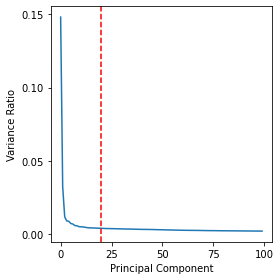

In [8]:
#Compute PCA: on "integrated" dataset. 
st.select_top_principal_components(adata_st, first_pc=True,n_pc= 20)

st.dimension_reduction(adata_st, method= 'umap',feature='top_pcs',n_components=6,n_neighbors=15,n_jobs=10)

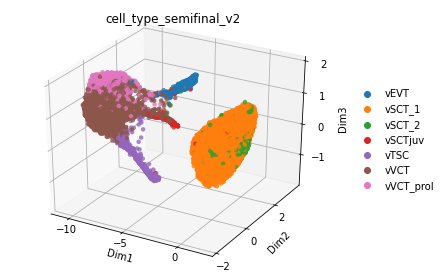

In [9]:
st.plot_dimension_reduction(adata_st,color=['cell_type_semifinal_v2'], show_graph=False,show_text=False)

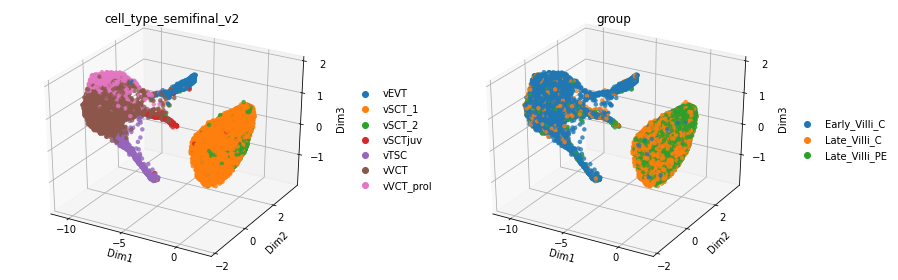

In [12]:
st.plot_dimension_reduction(adata_st,color=['cell_type_semifinal_v2', 'group'], show_graph=False,show_text=False)

Specifically, the final trajectory analysis was restricted to the early trophoblast cell types since in late controls, a striking discrepancy in cell-type composition and stem cell population depletion exist and may not allow an accurate trajectory analysis.

In [13]:
#Subset early_villi:
include= ['Early_Villi_C']

adata_early = adata_st[adata_st.obs['group'].isin(include)]

Importing precomputed principal components
10 PCs are selected
feature top_pcs is being used ...
8 cpus are being used ...


/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^




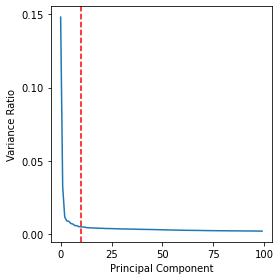

In [14]:
#Recompute PCA:
st.select_top_principal_components(adata_early, first_pc=True,n_pc=10)

#UMAP of early trophoblasts: 
st.dimension_reduction(adata_early, method= 'umap',feature='top_pcs',n_components=6,n_neighbors=15,n_jobs=8)

In [15]:
#Change the color codes to match that of UMAP: 
adata_early.uns['cell_type_semifinal_v2_color']= {'vSCT_1': '#ff99cc',
 'vSCT_2': '#ff0080',
 'vVCT': '#00b3b3',
 'vVCT_prol': '#004d4d',
 'vEVT': '#5c7aff',
 'vSCTjuv': '#cc33ff',
 'vTSC': '#ff0000'}

In [16]:
st.set_figure_params(dpi= 80,style='white', rc={'image.cmap': 'RdBu_r'})

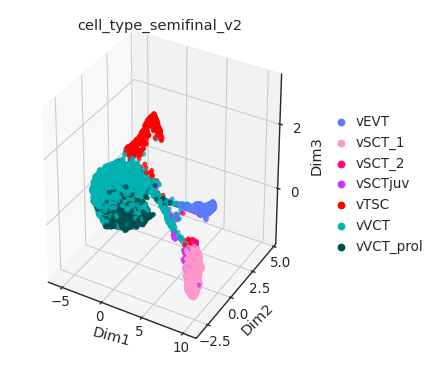

In [18]:
st.plot_dimension_reduction(adata_early,color=['cell_type_semifinal_v2'],n_components=3) #save_fig= True

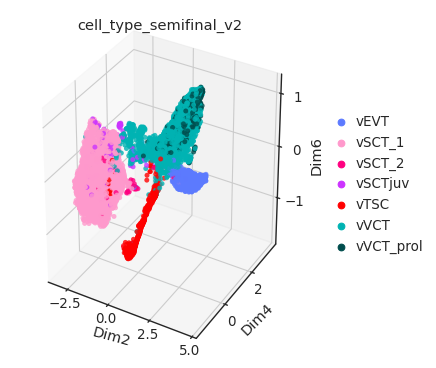

In [19]:
#Inspect different components of UMAP: we've resolved all the trophoblast cell-types well to move head with principal graph learning.
#Very importantly, the TSC (stem cells) are finely resolved & showing a clear transition to the vVCTs. 
st.plot_dimension_reduction(adata_early,color=['cell_type_semifinal_v2'], comp1=1, comp2=3, comp3=5, 
                            show_graph=False,show_text=False)

Seeding the initial tree structure (notes from the original publication):

The principal graph inference is based on a greedy optimization procedure that may lead to local minima. The initialization method proposed by STREAM is shown to improve the quality of the inferred solutions and that in turn, speed up convergence. At first, the cells are clustered in the UMAP space (alternatively, one can use MLLE/SE) using the K-means method (alternatively, one can use affinity propagation method with a damping factor= 0.75). Based on the exemplars obtained, a minimum spanning tree (MST) is constructed using the Kruskal’s algorithm. The obtained tree serves as initial tree structure for the ElPiGraph procedure.

In [20]:
#Set seed of the elastic graph:
#use: k-means clustering.
st.seed_elastic_principal_graph(adata_early,n_clusters= 10)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 5


Elastic Principal Graphs:

Elastic principal graphs are structured data approximators consisting of vertices connected by edges. The vertices are embedded into the space of the data & minimizes the mean squared distance (MSD) to the data points (similar to that of k-means). Unlike unstructured k-means, the edges connecting the vertices are used to define an elastic energy term. The elastic energy term and MSD are used to create penalties for edge stretching and bending of branches. To derive the optimal graph structure, ElPiGraph uses a topological grammar (or, graph grammar) approach, which is described in the original paper: https://www.nature.com/articles/s41467-019-09670-4

To learn principal graph in high-dimensional spaces, the procedure is as follows (taken from the main paper). Let H be the number of UMAP components.Then, the algorithm uses top L components to obtain a tree in a low dimensional subspace. Based on this tree, we calculate a principal graph in the L-dimensional space. Subsequently, the algorithm maps the learnt principal graph to the H-dimensional space such that for the coordinates of each node in the H-dimensional space, we obtain the first L coordinates from the L-dimensional space. For the other H−L coordinates, mean values of the coordinate of the cells assigned to a given node are used. If a given node does not have any assigned cells, inference the coordinates are done using k-nearest-neighbor strategy, i.e., the mean value of the nearest k cells is used to infer the node coordinate. The edges are instead preserved from the L-dimensional space. The node coordinate and edge information are then used to initialize a second-round of elastic principal graph inference in the H-dimensional space.

In [21]:
#Topological grammar: recapitulate the biological trajectory with the help of 'Elastic Principal Graph'.  
st.elastic_principal_graph(adata_early,epg_alpha=0.017,epg_mu=0.08,epg_lambda=0.01, n_jobs=8)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 8691 points and 6 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

3||50
	
0.7404
	
50
	
49
	
42
	
3
	
0
	
0
	
0.4961
	
0.4719
	
0.9864
	
0.987
	
0.1921
	
0.05229
	
2.614
	
130.7
	
0


38.307 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 7


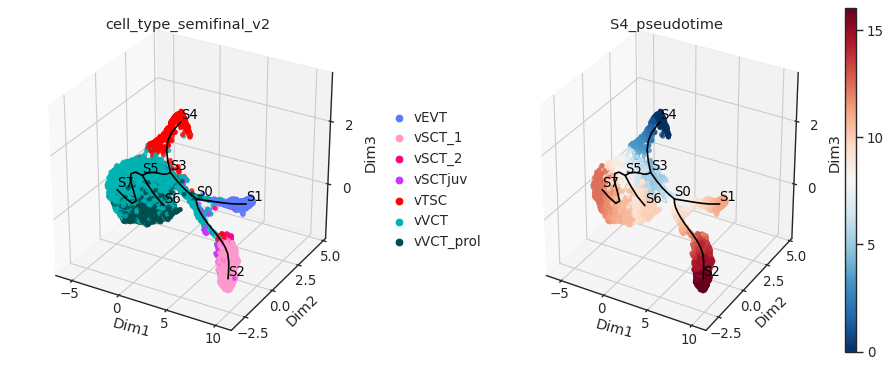

In [22]:
#Principal graph reconstructs the known biological trajectory of trophoblasts: 
st.plot_dimension_reduction(adata_early,color=['cell_type_semifinal_v2', 'S4_pseudotime'],n_components=3,
                            show_graph=True,show_text=True) #save_fig= True

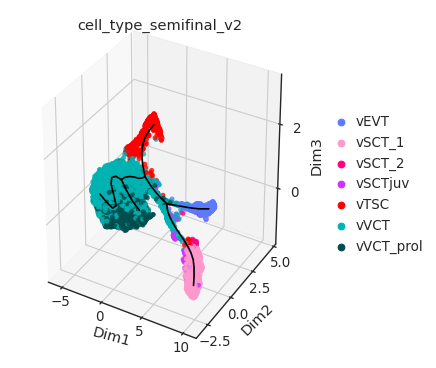

In [23]:
#Just plot the set of curves: 
#TSC > VCT > EVT & SCT (two separate fates) => Eureka! 
#Used as Extended figure 5E. 
st.plot_dimension_reduction(adata_early,color=['cell_type_semifinal_v2'],n_components=3,
                            show_graph=True,show_text=False) #save_fig= True

Flat trees for 2D visualization: visualizes trajectories as linear segments on a 2D plane. 
    
Branches are represented as straight lines and each circle represents a single-cell. The lengths of the branches and the distances between cells and their assigned branches are preserved from the space where trajectories were inferred.The lengths of tree branches are approximated from the UMAP embedding (or higher dimensional space) & then is mapped to a 2D plane based on a modified version of the force-directed layout Fruchterman-Reingold algorithm. Each node in the tree indicates one cell state. 

For more information, please refer to STREAM orginal publication: https://www.nature.com/articles/s41467-019-09670-4

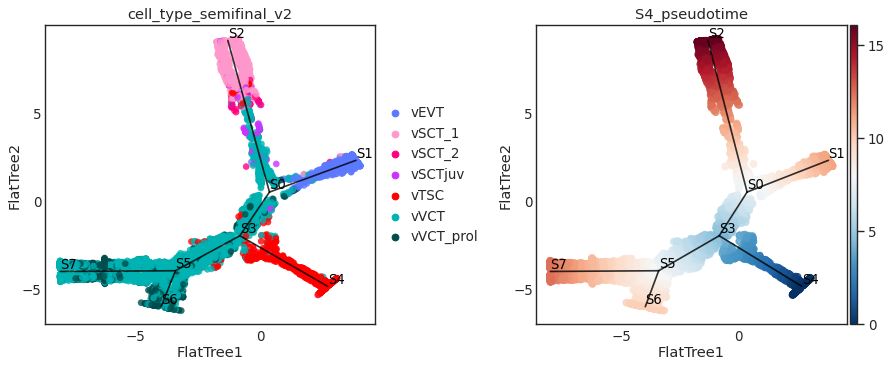

In [24]:
#Plot the 2D flat-tree:
st.plot_flat_tree(adata_early,color=['cell_type_semifinal_v2', 'S4_pseudotime'],
                  dist_scale=0.5,show_graph=True,show_text= True) 

Stream Plot:

In this intuitive plot, the length of each branch represents pseudotime, whereas the width is directly proportional to the number of cells at a given position. While visualizing gene expression, the algorithm considers for each sliding window, not only the number of cells but also their average gene expression values smoothed by bicubic interpolation (the maximum value is set as the nintieth percentile of the average gene expression values from all the sliding windows). For more information, refer to: https://www.nature.com/articles/s41467-019-09670-4

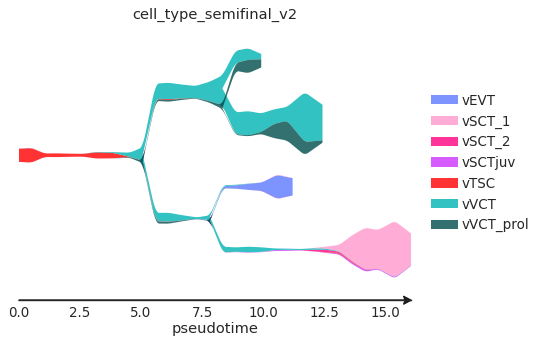

In [25]:
#Stream plot: Illustrated in main figure.2. 
st.plot_stream(adata_early,root= 'S4',color=['cell_type_semifinal_v2'], dist_scale=1)

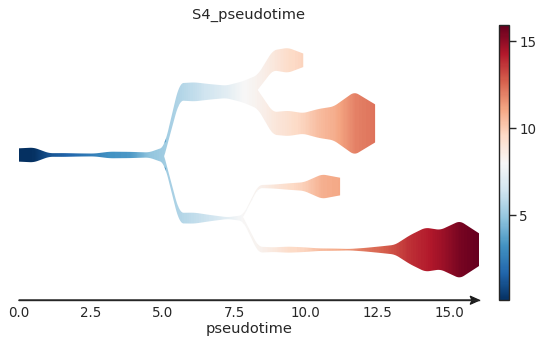

In [26]:
#root is set to S4 (i.e., TSC according to prior biological knowledge)
#Extended figure 5a.  
st.plot_stream(adata_early,root= 'S4',color=['S4_pseudotime'], dist_scale=1)

In [30]:
#Read the normalized data for pseudotime marker analysis: 

#adata_norm = sc.read_h5ad("./trophoblast_anndata/Placenta_normalized_data.h5ad")

#adata_norm

In [32]:
#Read the trophoblast normalized data for pseudotime marker analysis: 

adata_norm = sc.read_h5ad("./trophoblast_anndata/early_trophoblast_normalized_data.h5ad")

adata_norm.obs['cell_type_semifinal_v2'].cat.categories

Index(['vEVT', 'vSCT_1', 'vSCT_2', 'vSCTjuv', 'vTSC', 'vVCT', 'vVCT_prol'], dtype='object')

In [34]:
adata_tropho_early= adata_norm.copy() #Make a copy of the normalized data

#Since the sequence/order of the cell barcodes exactly match for both adata_early (integrated) & adata_tropho_early/adata_norm (normalized), 
#we can transfer all the pseudotime & branch coordinates information from adata_early.obs & adata_early.uns to the obs/uns of "adata_tropho_early"
#This step is necessary to proceed with leaf/transition/diverging gene computation. Normalized data is preferable. 

#Copy the .uns & .obsm back to the normalized data: 
adata_tropho_early.uns = adata_early.uns 
adata_tropho_early.obsm= adata_early.obsm 

#Copy all the branch information/coordinates: 
adata_tropho_early.obs['branch_id']= adata_early.obs['branch_id'] 
adata_tropho_early.obs['branch_lam']= adata_early.obs['branch_lam'] 
adata_tropho_early.obs['branch_id_alias']= adata_early.obs['branch_id_alias'] #S4_pseudotime: main ordering of cells.
adata_tropho_early.obs['branch_dist']= adata_early.obs['branch_dist']
adata_tropho_early.obs['node']= adata_early.obs['node']

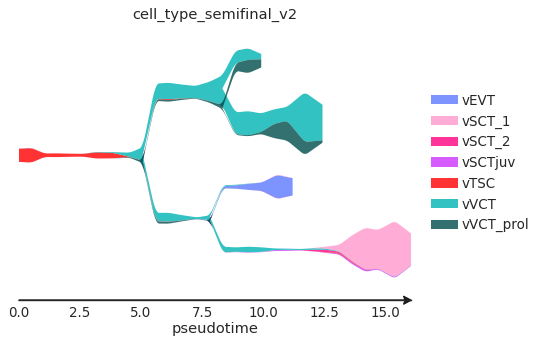

In [35]:
#Plot the stream trajectory to confirm if all the branch coordinates are correctly transferred. 
st.plot_stream(adata_tropho_early,root= 'S4',color=['cell_type_semifinal_v2'], dist_scale=1) #done! 

In [36]:
st.set_figure_params(dpi= 100,style='white', rc={'image.cmap': 'RdBu_r'})

In [38]:
#Copy the inferred pseudotime value: root is set at TSC. Corresponding .obs key is 'S4_pseudotime' representing the ordering of cells.
adata_tropho_early.obs['S4_pseudotime']= adata_early.obs['S4_pseudotime']  

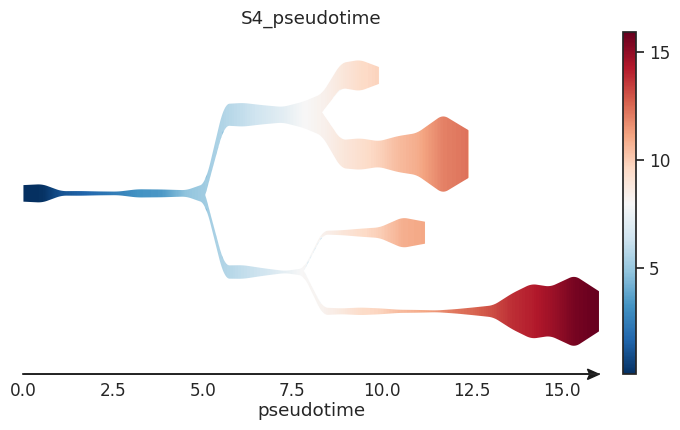

In [40]:
st.plot_stream(adata_tropho_early,root= 'S4',color=['S4_pseudotime'], dist_scale=1) #done! 

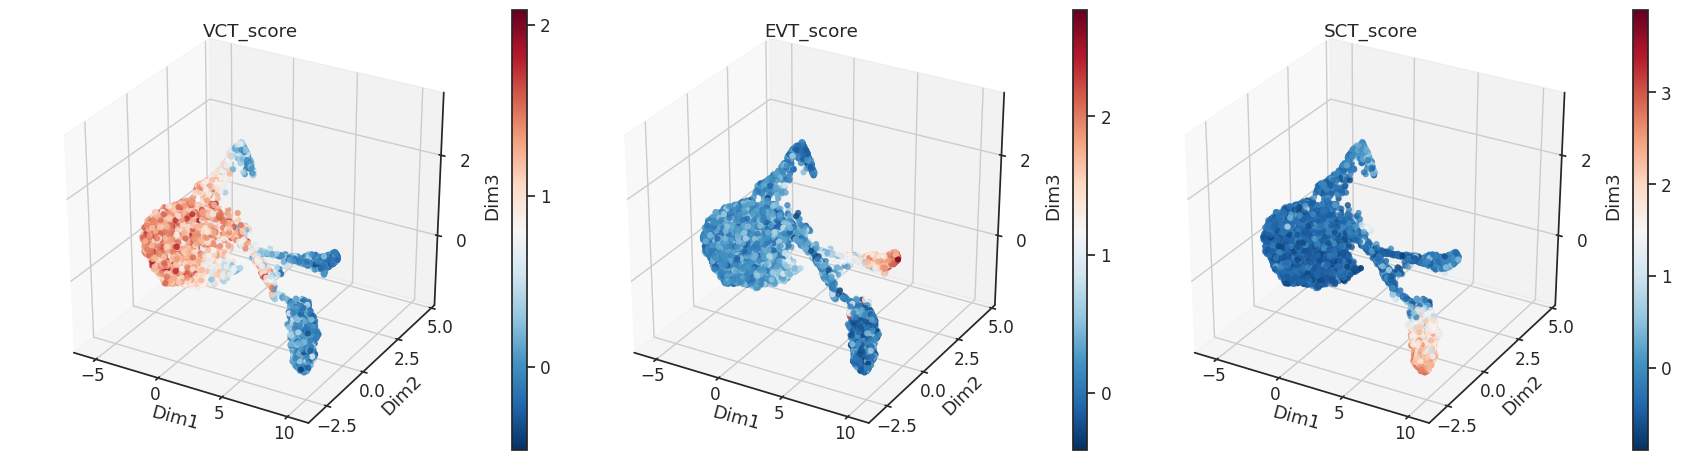

In [41]:
#Calculate SCT, VCT & EVT gene signature scores on the trajectory: internal validation of trajectory branches. 
vct_gene_list= ['PARP8', 'PAGE4', 'TENM3', 'ADAMTS19', 'LGR5', 'TP63', 'PARP1', 'CD24', 'TOP2A', 'MKI67',
               'PEG10', 'YAP1', 'PBX1', 'FBN2']

evt_gene_list= ['MYCNUT', 'NOTUM', 'TCF7L2', 'FN1', 'DIO2', 'TEAD1', 'FOXJ3', 'KRT7', 'KRT8', 'GATA3', 'MYCNOS', 'HLA-G']
sct_gene_list= ['CSH1', 'CSH2', 'KISS1', 'KYNU', 'PAPPA2', 'PAPPA', 'LIFR', 'ADAMTS6', 'CGA', 'KLRD1', 'ADGRG6']

#Compute individual module scores for each lineages. 
sc.tl.score_genes(adata_tropho_early, vct_gene_list, score_name= 'VCT_score')
sc.tl.score_genes(adata_tropho_early, evt_gene_list, score_name= 'EVT_score')
sc.tl.score_genes(adata_tropho_early, sct_gene_list, score_name= 'SCT_score')

st.plot_dimension_reduction(adata_tropho_early,color=['VCT_score', 'EVT_score', 'SCT_score'], show_graph=False,show_text=False)

/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning:

invalid value encountered in true_divide

/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning:

invalid value encountered in greater_equal



1565 variable genes are selected


/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/stream/core.py:867: RuntimeWarning:

invalid value encountered in less

/home/debnatho/anaconda3/envs/stream_pseudotime/lib/python3.6/site-packages/stream/core.py:872: RuntimeWarning:

invalid value encountered in less_equal



Index(['SEMA6D', 'TENM3', 'F13A1', 'SLIT2', 'ARL15', 'FN1', 'RHEX', 'EGFL7',
       'IGFBP3', 'KANK1',
       ...
       'AL158209.1', 'NFE2L3', 'NOS2', 'FOSL2', 'SLC35B4', 'RPS27A',
       'LINC01443', 'KCNH5', 'KIF14', 'TUBB'],
      dtype='object', name='index', length=1565)

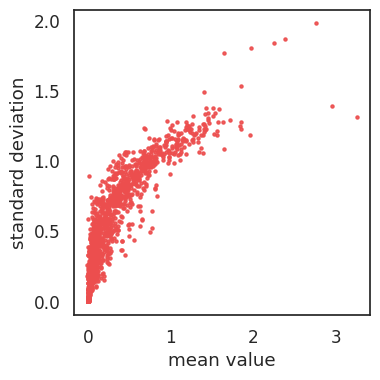

In [45]:
st.select_variable_genes(adata_early,loess_frac=0.05, percentile= 90)

adata_early.uns['var_genes']

In [46]:
#Genes used for constructing the trajectory principal graph should be used for identifying the leaf/transition genes.Alternatively, 
#one can use all the genes like the marker analysis. However, it will be time-consuming & memory extensive. But you'll find the major lineage drivers in any case. 

#Copy the "var_genes" slot from the #Integrated data. 
var_genes= adata_early.uns['var_genes'] 
var_genes

Index(['SEMA6D', 'TENM3', 'F13A1', 'SLIT2', 'ARL15', 'FN1', 'RHEX', 'EGFL7',
       'IGFBP3', 'KANK1',
       ...
       'AL158209.1', 'NFE2L3', 'NOS2', 'FOSL2', 'SLC35B4', 'RPS27A',
       'LINC01443', 'KCNH5', 'KIF14', 'TUBB'],
      dtype='object', name='index', length=1565)

In [47]:
#Make a copy of "adata_tropho_early": 
adata_leaf= adata_tropho_early.copy()

#Subset with only "var genes":
adata_leaf= adata_leaf[:,var_genes]
adata_leaf.uns['var_genes']

Index(['SEMA6D', 'TENM3', 'F13A1', 'SLIT2', 'ARL15', 'FN1', 'RHEX', 'EGFL7',
       'IGFBP3', 'KANK1',
       ...
       'AL158209.1', 'NFE2L3', 'NOS2', 'FOSL2', 'SLC35B4', 'RPS27A',
       'LINC01443', 'KCNH5', 'KIF14', 'TUBB'],
      dtype='object', name='index', length=1565)

In [48]:
adata_leaf.uns['workdir']

'./TSC_stream_latest'

In [50]:
adata_leaf.X = adata_leaf.X.toarray() 

In [51]:
#PART-II: Analyze leaf markers (all) for early villi for characterizing each lineage branches & terminal states. 
#Inferred by comparing multiple branches & relates to different committed states used for distinguishing lineages.

st.detect_leaf_markers(adata_leaf, cutoff_zscore=1.0,cutoff_pvalue=0.01, 
                       root='S4',n_jobs=26, use_precomputed=False)

Scanning all features ...
Filtering out markers that are expressed in less than 5 cells ...
26 cpus are being used ...
1510 markers are being scanned ...


In [52]:
#Detect transition markers: dynamical genes & can be thought as developmental drivers.  
st.detect_transition_markers(adata_leaf,cutoff_spearman=0.4,cutoff_logfc=0.20, root= 'S4',n_jobs= 20, use_precomputed=False)

Scanning all features ...
Filtering out markers that are expressed in less than 5 cells ...
20 cpus are being used ...
1510 markers are being scanned ...


In [53]:
#Detect marker genes that are differentially expressed between pairs of branches: not shown in the manuscript but quite interesting. 
#A major number of leaf/transition falls under this category. 

st.detect_de_markers(adata_leaf,cutoff_zscore=1,cutoff_logfc=0.20, root='S4',n_jobs= 20, use_precomputed=False)

Scanning all features ...
Filtering out markers that are expressed in less than 5 cells ...
20 cpus are being used ...
1510 markers are being scanned ...


In [59]:
#st.plot_de_markers(adata_leaf) #to save figure add => save_fig=True

In [58]:
#st.plot_stream_sc(adata_leaf, color= ['cell_type_semifinal_v2'], root= 'S4')

Selective transition genes having clear biological significance are plotted (as a function of pseudotime). A couple of transition genes are also leaf genes as their expression dynamically varies upto a point & then ~constant level.

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
#EVT lineage path:
#Subset EVT lineage: the branches leading to extravillous trophoblast starting from root node vTSC. 
evt_clusters= [('S4', 'S3'), ('S1', 'S0'), ('S0', 'S3')]

adata_evt= adata_leaf[adata_leaf.obs['branch_id_alias'].isin(evt_clusters)]
adata_evt.obs['branch_id_alias'].value_counts()

(S1, S0)    695
(S4, S3)    561
(S0, S3)    387
Name: branch_id_alias, dtype: int64

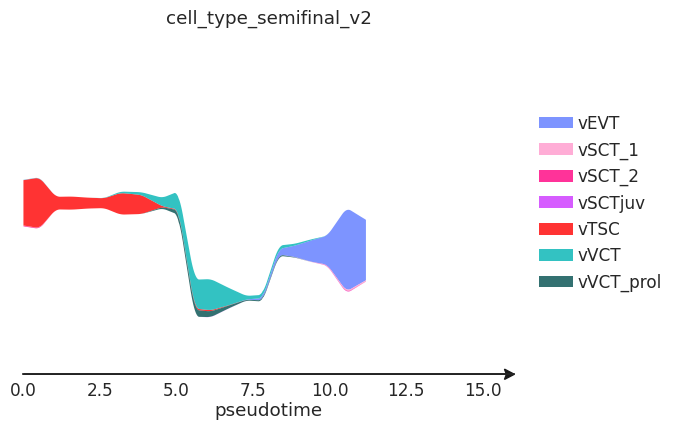

In [62]:
st.plot_stream(adata_evt,root= 'S4', color= ['cell_type_semifinal_v2'])

Text(0.5, 0, 'Cell-to-cell distance')

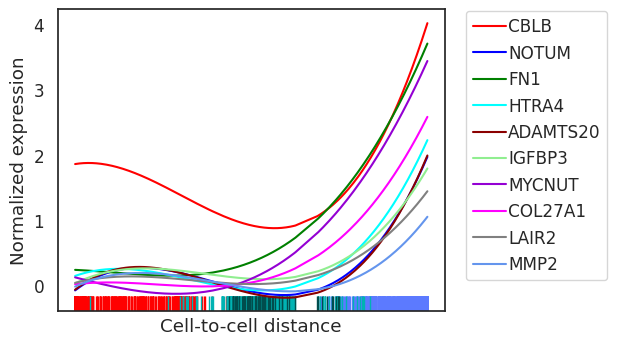

In [63]:
#Choose biologically & statistically relevant EVT genes: 10 only. 
#Main 2G: EVT. 
evt_genes= ['CBLB', 'NOTUM', 'FN1', 'HTRA4', 'ADAMTS20', 'IGFBP3', 'MYCNUT', 'COL27A1',
           'LAIR2', 'MMP2']

df=pd.DataFrame(adata_evt[:,evt_genes].copy().X,columns=evt_genes)

df['pseudotime']= adata_evt.obs['S4_pseudotime'].values
df['clusters']= adata_evt.obs['cell_type_semifinal_v2'].values

df=df.sort_values(by='pseudotime',ascending=True)


#Subset EVT lineage: TSC, VCT, EVT.
evt_clusters_include= ['vTSC', 'vVCT', 'vEVT', 'vVCT_prol']

adata_evt_new = adata_evt[adata_evt.obs['cell_type_semifinal_v2'].isin(evt_clusters_include)]
adata_evt_new.obs['cell_type_semifinal_v2'].cat.categories

#Include the corresponding color codes: 
col_clust= ['#5c7aff', '#ff0000', '#00b3b3', '#004d4d']

plt.rcParams['figure.figsize'] = (5, 4)

fig,ax=plt.subplots()

cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','magenta',
      'grey','cornflowerblue','lightsalmon', 'peru',
     'pink', 'yellow']

for i,gene in enumerate(evt_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_evt_new.obs['cell_type_semifinal_v2'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')
#plt.savefig("EVT_transitionGenes_early_ver01.pdf", dpi=800, papertype= "executive", bbox_inches='tight')
#plt.savefig("EVT_transitionGenes_early_ver01.svg", dpi=800, papertype= "executive", bbox_inches='tight')

In [64]:
#SCT lineage path:
#Subset SCT specific branch: starting from TSC to the SCT terminal node.  
sct_clusters= [('S4', 'S3'), ('S0', 'S3'), ('S2', 'S0')]
adata_sct= adata_leaf[adata_leaf.obs['branch_id_alias'].isin(sct_clusters)]


adata_sct.obs['cell_type_semifinal_v2'].cat.categories

#Include the corresponding SCT lineage color codes: 
sct_col_clust= ['#5c7aff', '#ff99cc', '#ff0080', '#ff0000', '#00b3b3', '#004d4d', '#cc33ff']

In [66]:
adata_sct.obs['cell_type_semifinal_v2'].cat.categories

Index(['vEVT', 'vSCT_1', 'vSCT_2', 'vSCTjuv', 'vTSC', 'vVCT', 'vVCT_prol'], dtype='object')

In [67]:
#Include the corresponding SCT lineage color codes: 
sct_col_clust= ['#5c7aff', '#ff99cc', '#ff0080', '#cc33ff', '#ff0000', '#00b3b3', '#004d4d']

Text(0.5, 0, 'Cell-to-cell distance')

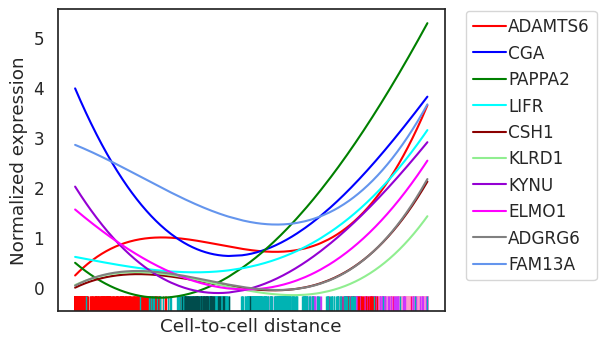

In [68]:
#Main 2G: Plot SCT lineage genes:
sct_genes=['ADAMTS6', 'CGA', 'PAPPA2', 'LIFR', 'CSH1', 'KLRD1', 'KYNU', 'ELMO1', 'ADGRG6', 'FAM13A'] 

df=pd.DataFrame(adata_sct[:,sct_genes].copy().X,columns=sct_genes)

df['pseudotime']=adata_sct.obs['S4_pseudotime'].values
df['clusters']=adata_sct.obs['cell_type_semifinal_v2'].values

df=df.sort_values(by='pseudotime',ascending=True)

plt.rcParams['figure.figsize'] = (5, 4)

fig,ax=plt.subplots()


cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','magenta',
      'grey','cornflowerblue','lightsalmon', 'peru',
     'pink', 'yellow']

for i,gene in enumerate(sct_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_sct.obs['cell_type_semifinal_v2'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=sct_col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')
#plt.savefig("vSCT_lowerBranch_transitionGenes_early_ver01.pdf", dpi=800, papertype= "executive", bbox_inches='tight')
#plt.savefig("vSCT_lowerBranch_transitionGenes_early_ver01.svg", dpi=800, papertype= "executive", bbox_inches='tight')

In [69]:
#Subset VCT lineage: or upper VCT specific branches. 
vct_clusters= [('S4', 'S3'), ('S5', 'S3'), ('S6', 'S5')]

adata_vct= adata_leaf[adata_leaf.obs['branch_id_alias'].isin(vct_clusters)]

#adata_vct.obs['branch_id_alias'].value_counts()

#Filter the SCT(s), EVT out of the VCT graph. 
vct_clusters_include= ['vTSC', 'vVCT', 'vVCT_prol']

adata_vct_new = adata_vct[adata_vct.obs['cell_type_semifinal_v2'].isin(vct_clusters_include)]

adata_vct_new.obs['cell_type_semifinal_v2'].cat.categories

#Include the corresponding color codes: 
vct_col_clust= ['#ff0000', '#00b3b3', '#004d4d']

#Show the very prominent VCT genes:main 2G.  
vct_genes= ['ARL15', 'FBN2', 'LGR5', 'PEG10', 'SMARCA2', 'TPK1', 'FRAS1', 'COLEC12', 'TEAD1', 'FLNB']

df=pd.DataFrame(adata_vct_new[:,vct_genes].copy().X,columns=vct_genes)

df['pseudotime']= adata_vct_new.obs['S4_pseudotime'].values
df['clusters']= adata_vct_new.obs['cell_type_semifinal_v2'].values

df=df.sort_values(by='pseudotime',ascending=True)

Text(0.5, 0, 'Cell-to-cell distance')

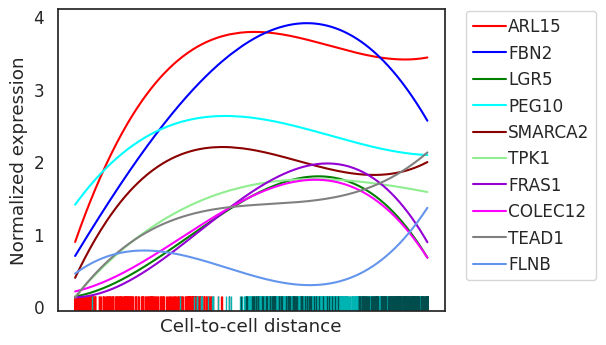

In [70]:
#Main 2G: VCT path. 

plt.rcParams['figure.figsize'] = (5, 4)

fig,ax=plt.subplots()

cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','magenta',
      'grey','cornflowerblue','lightsalmon', 'peru',
     'pink', 'yellow']

for i,gene in enumerate(vct_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_vct_new.obs['cell_type_semifinal_v2'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=vct_col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')
#plt.savefig("VCT_upperBranch_transitionGenes_early_ver01.pdf", dpi=800, papertype= "executive", bbox_inches='tight')
#plt.savefig("VCT_upperBranch_transitionGenes_early_ver01.svg", dpi=800, papertype= "executive", bbox_inches='tight')

In [71]:
st.write(adata_tropho_early,file_name= 'Early_placenta_pseudotime_normalized.pkl')